In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from PIL import Image

C:\Users\user\AppData\Local\Temp\ipykernel_21332\4229558788.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
excel_file="data.xlsx"

In [3]:
data = pd.read_excel(excel_file, sheet_name=None)
peach_data = data["Peach"]

In [4]:
peach_data_top = peach_data[["File name", "% Waste"]]
peach_data_top.dropna(inplace=True)

peach_data_side = peach_data[["File name.1", "% Waste.1"]]

peach_data_side.rename(columns={"File name.1": "File name", "% Waste.1": "% Waste"},inplace=True)
peach_data_side.dropna(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_21332\4094097339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peach_data_top.dropna(inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_21332\4094097339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peach_data_side.rename(columns={"File name.1": "File name", "% Waste.1": "% Waste"},inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_21332\4094097339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [5]:
peach_data_top

,File name,% Waste
0,20230718_peach_01_top_01,6.211873
1,20230718_peach_02_top_01,26.893904
2,20230719_peach_01_top_01,4.288291
3,20230719_peach_02_top_01,4.424803
4,20230719_peach_03_top_01,6.132037
...,...,...
120,20231013_peach_12_top_01,6.210898
121,20231013_peach_13_top_01,22.820151
122,20231013_peach_14_top_01,20.298928
123,20231013_peach_15_top_01,23.863501


In [6]:
peach_data_side

,File name,% Waste
0,20230718_peach_01_side_01,6.211873
1,20230718_peach_02_side_01,26.893904
2,20230719_peach_01_side_01,4.288291
3,20230719_peach_02_side_01,4.424803
4,20230719_peach_03_side_01,6.132037
...,...,...
125,20231013_peach_12_side_01,6.210898
126,20231013_peach_13_side_01,22.820151
127,20231013_peach_14_side_01,20.298928
128,20231013_peach_15_side_01,23.863501


In [7]:
data = pd.concat([peach_data_side,peach_data_top], axis=0)

In [8]:
data

,File name,% Waste
0,20230718_peach_01_side_01,6.211873
1,20230718_peach_02_side_01,26.893904
2,20230719_peach_01_side_01,4.288291
3,20230719_peach_02_side_01,4.424803
4,20230719_peach_03_side_01,6.132037
...,...,...
120,20231013_peach_12_top_01,6.210898
121,20231013_peach_13_top_01,22.820151
122,20231013_peach_14_top_01,20.298928
123,20231013_peach_15_top_01,23.863501


<Axes: >

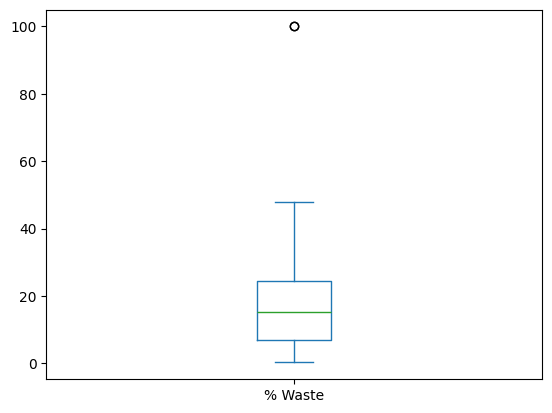

In [9]:
data.plot.box()

In [10]:
actual_waste = data["% Waste"]
baseline_prediction = np.mean(data["% Waste"]) 

# Generate baseline predictions for all samples
baseline_predictions = np.full_like(actual_waste, baseline_prediction)

# Calculate RMSE for baseline predictions
baseline_rmse = np.sqrt(mean_squared_error(actual_waste, baseline_predictions))



print("Baseline RMSE:", baseline_rmse)

Baseline RMSE: 13.390269000324619


Extraction Color Histograms and Training Models

In [11]:
# Function to extract histogram features from image files
def extract_histogram(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise Exception(f"Failed to open image '{image_path}'")
        hist = cv2.calcHist(
            [image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]
        )
        hist = cv2.normalize(hist, hist).flatten()
        return hist
    except Exception as e:
        print(f"Error processing image '{image_path}': {e}")
        return None


# Extracting histogram features from filenames
peach_folder = "cropped_peach"
data["Histogram"] = data["File name"].apply(
    lambda x: extract_histogram(os.path.join(peach_folder, x + ".jpg"))
)

# Remove rows where the histogram extraction failed
data = data.dropna()

# Preparing features and target
X = np.vstack(data["Histogram"]).astype(float)
y = data["% Waste"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Training regression models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name}: RMSE = {rmse}")

Error processing image 'cropped_peach\20231006_peach_17_side_01.jpg': Failed to open image 'cropped_peach\20231006_peach_17_side_01.jpg'
Error processing image 'cropped_peach\20231004_peach_05_top_01.jpg': Failed to open image 'cropped_peach\20231004_peach_05_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_14_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_14_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_15_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_15_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_16_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_16_top_01.jpg'
Error processing image 'cropped_peach\20231006_peach_17_top_01.jpg': Failed to open image 'cropped_peach\20231006_peach_17_top_01.jpg'
Error processing image 'cropped_peach\20231011_peach_01_top_02.jpg': Failed to open image 'cropped_peach\20231011_peach_01_top_02.jpg'
Random Forest: RMSE = 9.431581179970365
XGBoost: RMSE

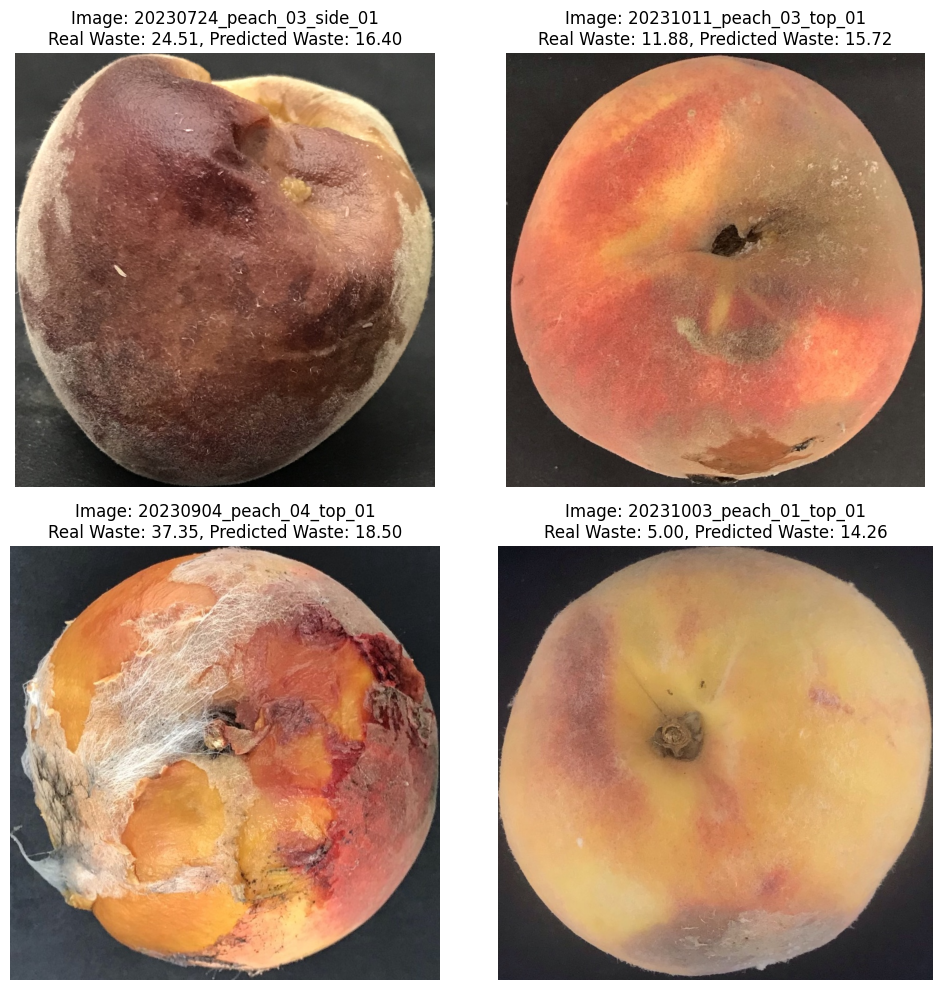

In [12]:

test_filenames = random.sample(
    data["File name"].tolist(), 4
)  # Select 4 images for a 2x2 grid
test_image_paths = [
    os.path.join(peach_folder, f"{filename}.jpg") for filename in test_filenames
]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Display real and predicted waste percentages for test images
for ax, image_path, filename in zip(axes.flatten(), test_image_paths, test_filenames):
    real_waste_percentage = data[data["File name"] == filename]["% Waste"].values[0]
    hist = extract_histogram(image_path)
    if hist is not None:
        hist = hist.reshape(1, -1)
        predicted_waste = model.predict(hist)[0]

        # Load and display the image using Matplotlib
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.set_title(
            f"Image: {filename}\nReal Waste: {real_waste_percentage:.2f}, Predicted Waste: {predicted_waste:.2f}"
        )
        ax.axis("off")  # Hide axes
    else:
        print(f"Image: {image_path}, Histogram extraction failed")

# Adjust layout
plt.tight_layout()
plt.show()

## DL Based Regression

In [20]:
train_df, test_df = train_test_split(data.dropna(), test_size=0.18, random_state=42)

train_df = train_df[
    train_df["File name"].apply(
        lambda x: os.path.exists(os.path.join("cropped_peach", x + ".jpg"))
    )
]
test_df = test_df[
    test_df["File name"].apply(
        lambda x: os.path.exists(os.path.join("cropped_peach", x + ".jpg"))
    )
]


val_df, test_df = train_test_split(test_df,test_size=0.5, random_state=42)

len(train_df),len(test_df), len(val_df)

(203, 23, 22)

In [21]:
train_df

,File name,% Waste,Histogram
120,20231013_peach_08_side_01,17.426260,"[0.31081295, 0.0026117677, 0.0006676384, 0.0, ..."
68,20231006_peach_13_side_01,23.387019,"[0.15817688, 0.005025319, 0.0, 0.0, 0.0, 0.0, ..."
51,20231004_peach_02_top_01,8.795523,"[0.24408616, 0.011738592, 1.8227627e-05, 0.0, ..."
38,20231002_peach_07_side_01,14.358468,"[0.45283583, 0.0010093485, 0.0, 0.0, 0.0, 0.0,..."
43,20231002_peach_12_top_01,1.036974,"[0.5073305, 0.013553848, 0.0002577177, 0.0, 0...."
...,...,...,...
107,20231011_peach_05_side_01,10.715369,"[0.07478849, 0.019793935, 3.2070537e-05, 0.0, ..."
14,20230803_peach_03_side_01,7.155886,"[0.28346574, 6.2531735e-06, 3.1265868e-06, 0.0..."
93,20231009_peach_08_side_01,4.499629,"[0.58009815, 0.058217444, 3.8047066e-05, 0.0, ..."
50,20231004_peach_01_top_01,15.015108,"[0.3538273, 0.015404593, 0.0, 0.0, 0.0, 0.0, 0..."


In [22]:
from torchvision import transforms


class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0] + ".jpg")
        if not os.path.exists(img_name):
            return None, None
        image = cv2.imread(img_name)
        label = self.dataframe.iloc[idx, 1]

        # Convert BGR image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert numpy array to PIL image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


# Define image transformations
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Define datasets and data loaders
train_dataset = CustomDataset(train_df, "cropped_peach", transform=train_transforms)
test_dataset = CustomDataset(test_df, "cropped_peach", transform=test_transforms)
val_dataset = CustomDataset(val_df, "cropped_peach", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


class RegressionModel(nn.Module):

    def __init__(self):

        super(RegressionModel, self).__init__()
        resnet = torchvision.models.resnet101(pretrained=True)
        self.features = nn.Sequential(
            *list(resnet.children())[:-1]
        )  # Remove the last fully connected layer
        self.regressor1 = nn.Linear(
            2048, 256
        )  # Replace the last layer with a regression layer
        self.regressor2 = nn.Linear(256, 1)

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor1(x)
        x = self.regressor2(x)
        return x


# Define the model
model = RegressionModel()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=3, verbose=True
)

# Early stopping
best_val_loss = float("inf")
patience = 10
counter = 0
best_model_weights = None

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False
    ):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_running_loss = 0.0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs.squeeze(), labels.float())
        val_running_loss += val_loss.item() * inputs.size(0)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}")

    # Learning rate scheduler step
    scheduler.step(val_epoch_loss)

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        # Save the best model weights
        best_model_weights = model.state_dict()

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break

# Load the best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

torch.save(model.state_dict(), "peach_regression_model.pth")
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():

    for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        predictions.extend(outputs.squeeze().tolist())

        true_labels.extend(labels.tolist())

mse = mean_squared_error(true_labels, predictions)
print(f"Root Mean Squared Error on Test Set: {np.sqrt(mse):.4f}")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/100], Training Loss: 249.0390
Epoch [1/100], Validation Loss: 91.6065


Epoch [2/100], Training Loss: 135.8800
Epoch [2/100], Validation Loss: 94.7760


Epoch [3/100], Training Loss: 92.4936
Epoch [3/100], Validation Loss: 82.0414


Epoch [4/100], Training Loss: 81.0555
Epoch [4/100], Validation Loss: 64.5082


Epoch [5/100], Training Loss: 61.7561
Epoch [5/100], Validation Loss: 60.0885


Epoch [6/100], Training Loss: 67.3846
Epoch [6/100], Validation Loss: 118.1965


Epoch [7/100], Training Loss: 44.0219
Epoch [7/100], Validation Loss: 52.6894


Epoch [8/100], Training Loss: 52.1430
Epoch [8/100], Validation Loss: 73.1922


Epoch [9/100], Training Loss: 46.5455
Epoch [9/100], Validation Loss: 80.4042


Epoch [10/100], Training Loss: 38.4781
Epoch [10/100], Validation Loss: 61.1678


Epoch [11/100], Training Loss: 54.3573
Epoch [11/100], Validation Loss: 119.6421


Epoch [12/100], Training Loss: 38.0291
Epoch [12/100], Validation Loss: 99.2336


Epoch [13/100], Training Loss: 27.2064
Epoch [13/100], Validation Loss: 78.9752


Epoch [14/100], Training Loss: 24.5503
Epoch [14/100], Validation Loss: 73.1317


Epoch [15/100], Training Loss: 18.7455
Epoch [15/100], Validation Loss: 63.4848


Epoch [16/100], Training Loss: 21.1974
Epoch [16/100], Validation Loss: 66.2898


Epoch [17/100], Training Loss: 18.0279
Epoch [17/100], Validation Loss: 67.1355
Early stopping...


Root Mean Squared Error on Test Set: 7.7907


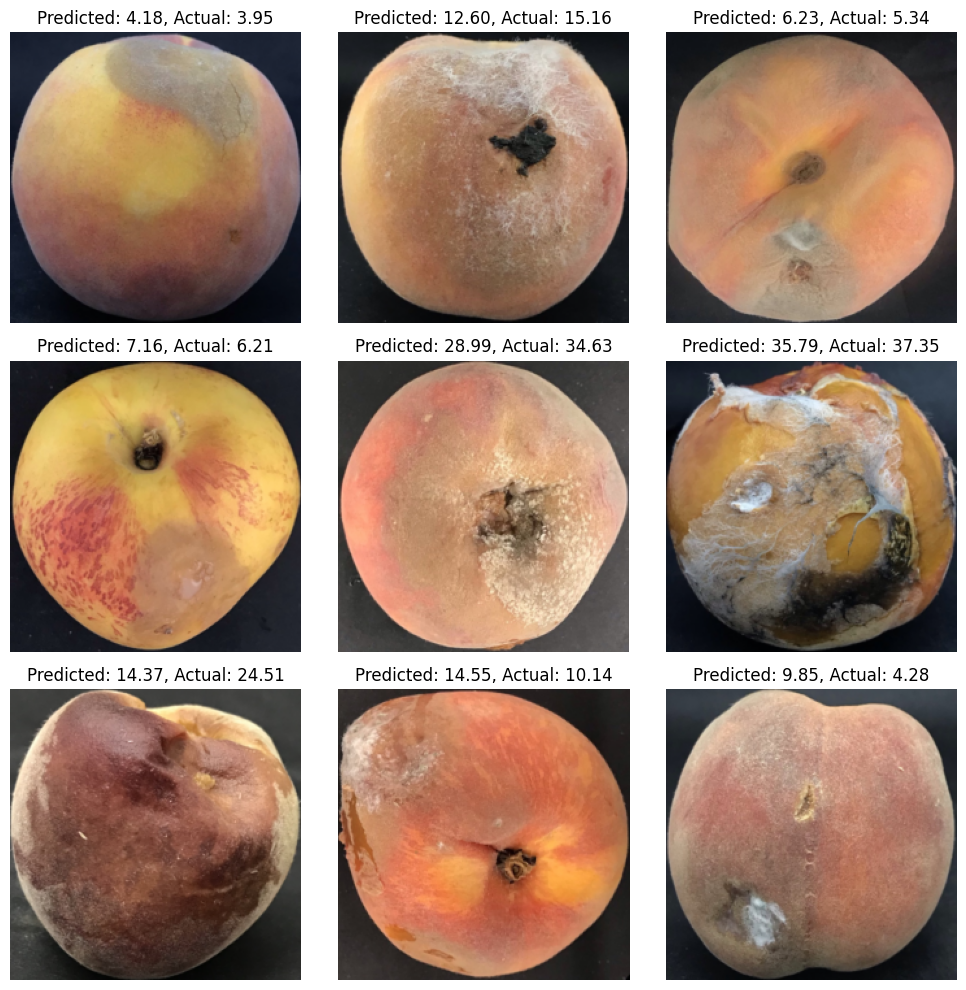

In [29]:
# Evaluation
model.eval()
with torch.no_grad():
    # Get random indices for 4 test images
    indices = np.random.choice(len(test_dataset), size=9, replace=False)

    # Create a subplot
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    for i, idx in enumerate(indices):
        inputs, label = test_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)
        output = model(inputs)
        prediction = output.item()

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = inputs.squeeze().permute(1, 2, 0).cpu().numpy()
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        # Display the image
        axs[i // 3, i % 3].imshow(img)
        axs[i // 3, i % 3].set_title(
            f"Predicted: {prediction:.2f}, Actual: {label:.2f}"
        )
        axs[i // 3, i % 3].axis("off")

    plt.tight_layout()
    plt.show()